In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import jax.random as jr
import pandas as pd

from uncprop.utils.experiment import Experiment
from uncprop.models.elliptic_pde.experiment import PDEReplicate
from uncprop.models.elliptic_pde.runner import run_pde_experiment

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_results, all_failed_experiments = run_pde_experiment()

Creating new output directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment
Creating experiment sub-directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment/n_design_8
Running replicate 0
	Fitting surrogate
	Running samplers
No save_results() methods implemented.
0 of 1 replicates failed.


# Investigate specific replicate

In [3]:
result_idx = 0
rep_idx = 0

results = all_results[result_idx]
rep = results[rep_idx]
posterior = rep.posterior

key = jr.key(1242131)

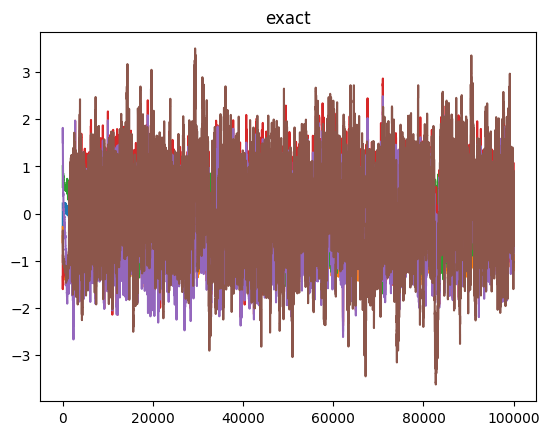

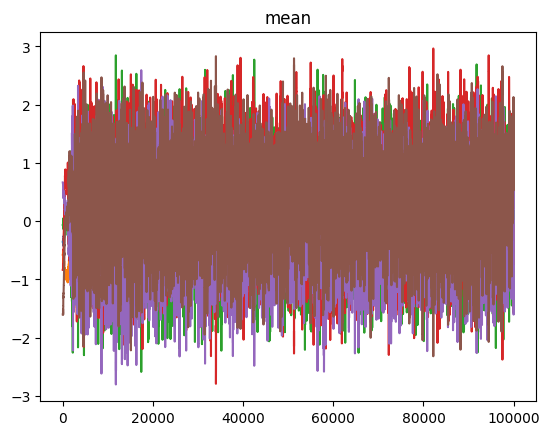

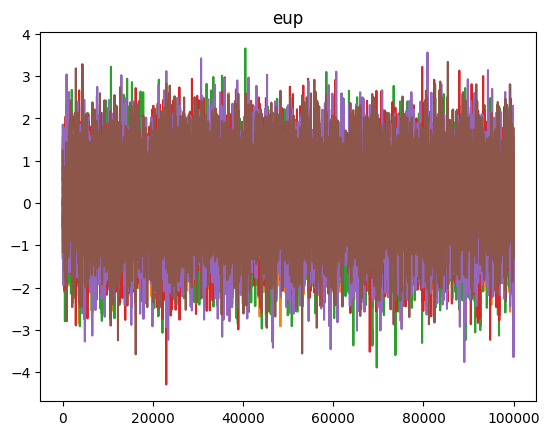

In [4]:
# MCMC trace
for mcmc_tag in ['exact', 'mean', 'eup']:
    samp = rep.samples[mcmc_tag]
    for i in range(posterior.dim):
        plt.plot(samp[:,i])
        plt.title(mcmc_tag)
    plt.show()

In [5]:
key_prior_samp, key = jr.split(key)
n_samp = 5000

samples = rep.samples
samples['prior'] = posterior.prior.sample(key_prior_samp, n=n_samp)

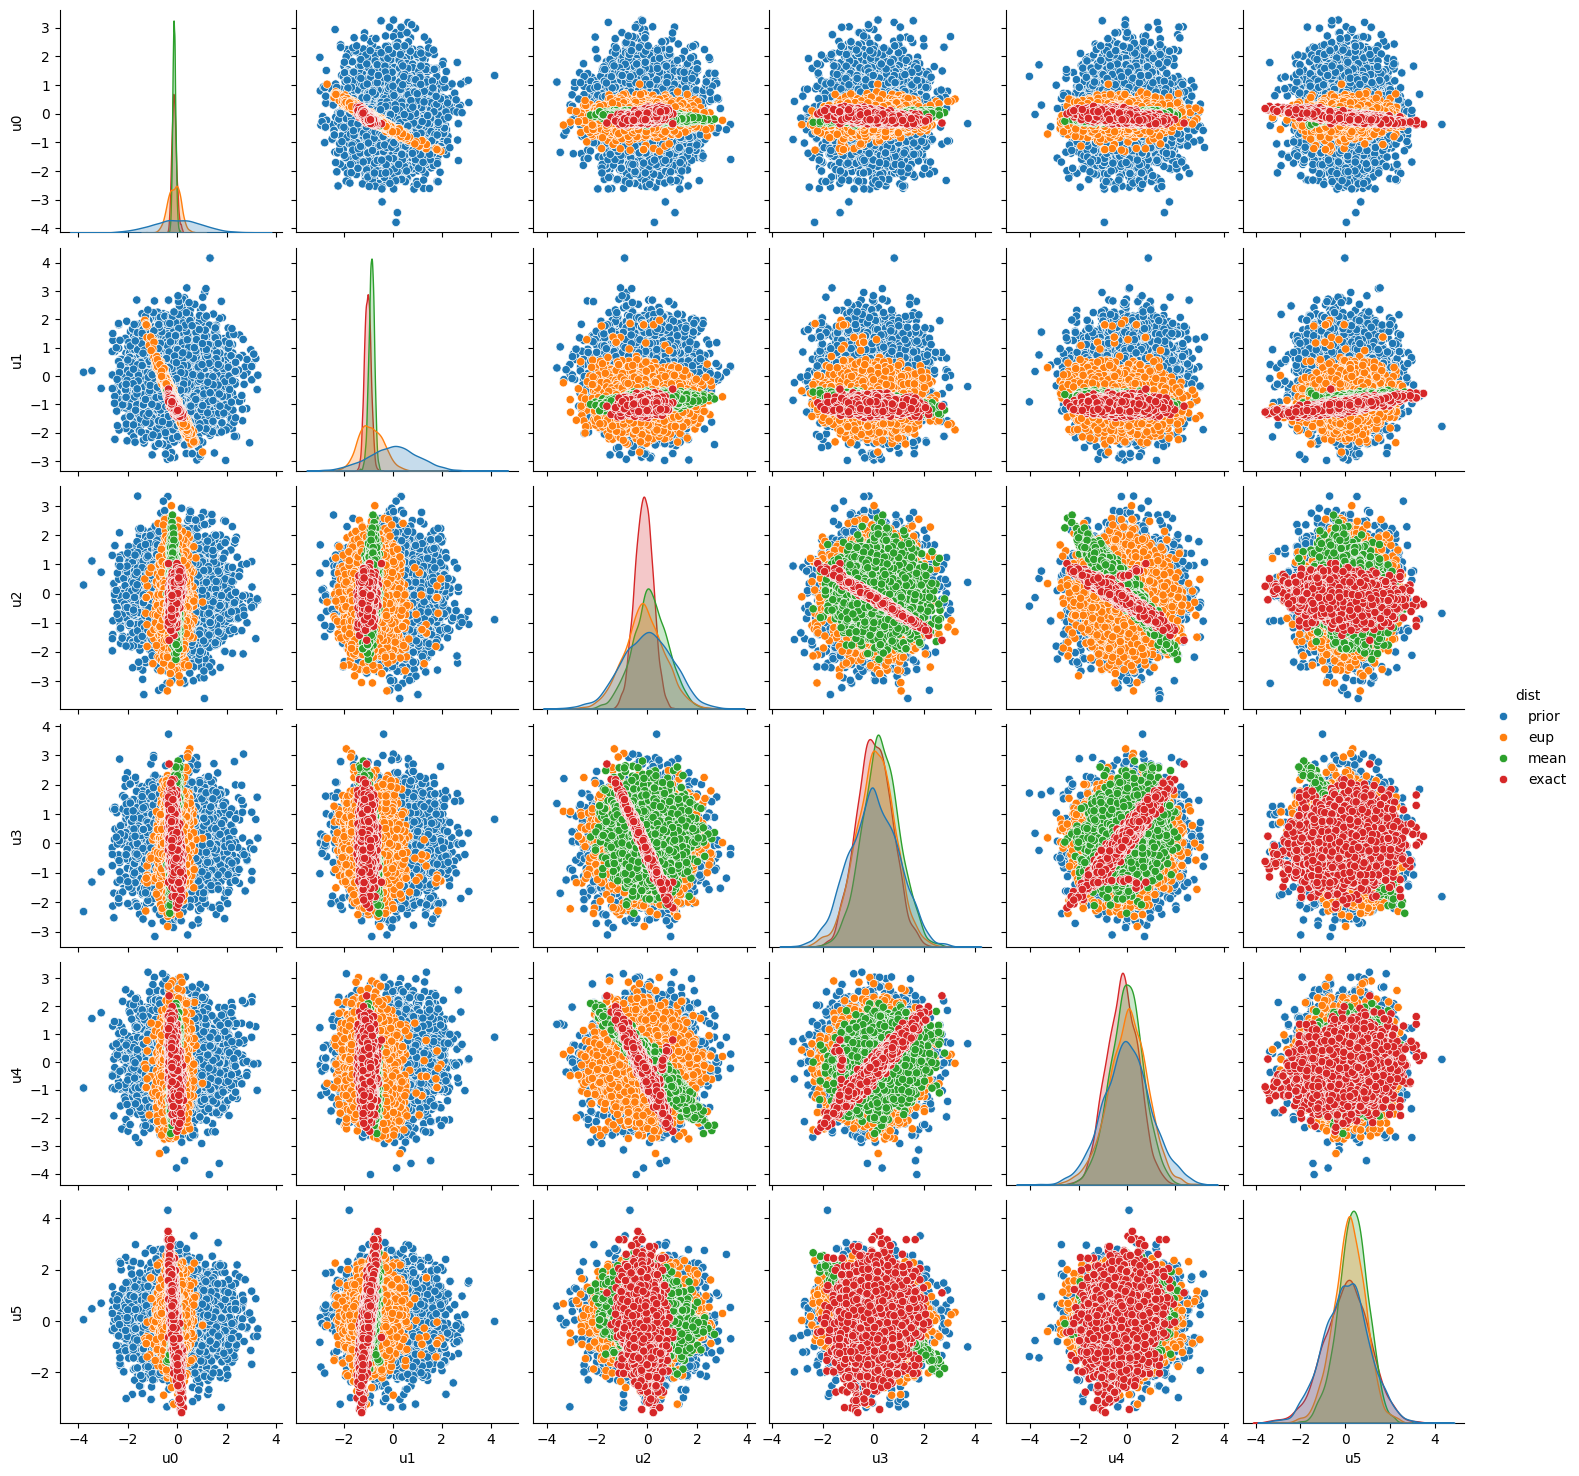

In [13]:
key_subsamp, key = jr.split(key)

dist_names = ['prior', 'eup', 'mean', 'exact']

df_list = []
for name in dist_names:
    idx = jr.choice(key_subsamp, samples[name].shape[0], (n_samp,))
    df = pd.DataFrame(samples[name][idx], columns=posterior.prior.par_names)
    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

In [ ]:
postsamp = samp[-50:,:]
param, log_field, pde_solution, observable = posterior.likelihood.forward_model.forward_with_intermediates(postsamp)
xgrid = posterior.likelihood.forward_model.pde_settings.xgrid

plt.plot(xgrid, pde_solution.T, color='gray')
plt.show()

### Test RFF approximation

In [ ]:
def check_rff_approx(key, posterior, surrogate, trajectories, n_test=500):
    inputs = posterior.prior.sample(key, n_test)

    pred = surrogate(inputs)
    pred_rff = trajectories(inputs)
    m = pred.mean
    sd = pred.stdev
    m_rff = jnp.mean(pred_rff, axis=0)
    sd_rff = jnp.std(pred_rff, axis=0)

    for i in range(surrogate.output_dim):
        fig, axs = plt.subplots(1, 2)
        axs = axs.ravel()
        axs[0].scatter(m[i], m_rff[i])
        axs[0].set_title('mean')
        xmin, xmax = axs[0].get_xlim()
        ymin, ymax = axs[0].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[0].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        axs[1].scatter(sd[i], sd_rff[i])
        axs[1].set_title('sd')
        xmin, xmax = axs[1].get_xlim()
        ymin, ymax = axs[1].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[1].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        fig.tight_layout()
        fig.show()

In [ ]:
from uncprop.models.elliptic_pde.surrogate import (
    _build_batch_basis_funcs,
    _build_batch_basis_noise_dist,
    sample_approx_trajectory,
)

num_rff = 1000
num_trajectories = 10_000

# create batch of trajectories
surrogate = rep.posterior_surrogate.surrogate
batchgp = rep.posterior_surrogate.batchgp

key, key_noise, key_rff, key_plot = jr.split(key, 4)
noise_dist = _build_batch_basis_noise_dist(surrogate, batchgp, num_rff)
noise_realization = noise_dist.sample(key_noise, num_trajectories)
basis_fn = _build_batch_basis_funcs(key_rff, surrogate, batchgp, num_rff)
trajectories = sample_approx_trajectory(basis_fn, noise_realization, surrogate, num_rff)

In [ ]:
check_rff_approx(key_plot, posterior, surrogate, trajectories, n_test=500)

### Testing new trajectory sampling

In [ ]:
key, key_traj = jr.split(key, 2)

post_traj = rep.posterior_surrogate.sample_trajectory(key_traj)

In [ ]:
from uncprop.core.samplers import sample_distribution
key, key_samp, key_init = jr.split(key, 3)

tester = sample_distribution(key=key_samp, 
                             dist=post_traj,
                             n_samples=10_000,
                             initial_position=posterior.prior.sample(key_init), 
                             n_warmup=10_000)

In [ ]:
tester['warmup_samp'].position.shape

In [ ]:
# positions = tester['positions'].squeeze(1)
positions = tester['warmup_samp'].position.squeeze(1)

for i in range(posterior.dim):
    plt.plot(positions[:, i])
plt.show()

### Testing trajectory sampling

In [ ]:
from uncprop.models.elliptic_pde.surrogate import (
    sample_approx_trajectory,
    _build_batch_basis_noise_dist,
    _build_batch_basis_funcs,
)

from uncprop.core.samplers import (
    sample_distribution
)

from uncprop.core.distribution import DistributionFromDensity

In [ ]:
key, key_rff = jr.split(key, 2)
surrogate = results[0].posterior_surrogate.surrogate
batchgp = results[0].batchgp

basis_fn = _build_batch_basis_funcs(key=key_rff, 
                                    surrogate=surrogate,
                                    batchgp=batchgp,
                                    num_rff=1000)

noise_dist = _build_batch_basis_noise_dist(surrogate=surrogate,
                                           batchgp=batchgp,
                                           num_rff=num_rff)

In [ ]:
num_rff = 1000
observable_to_logdensity = posterior.likelihood.observable_to_logdensity

def logdensity(basis_weights, u):
    trajectory = sample_approx_trajectory(basis_fn, basis_weights, surrogate, num_rff)
    fu = trajectory(u).squeeze(0)
    return observable_to_logdensity(fu)

In [ ]:
key, key_weights, key_prior = jr.split(key, 3)
num_rff = 1000
observable_to_logdensity = posterior.likelihood.observable_to_logdensity

basis_weights = noise_dist.sample(key_weights)
u = posterior.prior.sample(key_prior)
trajectory = sample_approx_trajectory(basis_fn, basis_weights, surrogate, num_rff)
fu = trajectory(u).squeeze()
log_post = observable_to_logdensity(fu)

# fu = logdensity(basis_weights, u) # (1, q, m)

In [ ]:
def _make_logdensity_fn(basis_weights, basis_fn):
    trajectory = sample_approx_trajectory(basis_fn, basis_weights, surrogate, num_rff)

    def logdensity(u):
        fu = trajectory(u).squeeze()
        return observable_to_logdensity(fu)

    return logdensity


def test_loop(key, basis_fn, noise_dist, n_chains, n_samples=100):
    weight_seed, sample_seed, init_pos_seed = jr.split(key, 3)
    weight_keys = jr.split(weight_seed, n_chains)
    sample_keys = jr.split(sample_seed, n_chains)
    initial_positions = posterior.prior.sample(init_pos_seed, n_chains)

    samp = jnp.zeros((n_chains, n_samples, posterior.dim))

    for i in range(n_chains):
        print(f'running chain {i}')

        basis_weights = noise_dist.sample(weight_keys[i])
        logdensity = _make_logdensity_fn(basis_weights, basis_fn)
        dist = DistributionFromDensity(logdensity, dim=posterior.dim, support=posterior.support)

        results = sample_distribution(key=sample_keys[i],
                                      dist=dist, 
                                      n_samples=n_samples, 
                                      initial_position=initial_positions[[i], ...], 
                                      n_chains=1, 
                                      n_warmup=10_000)

        positions = results['positions'].squeeze(1)
        samp[i] = positions

    return samp

In [ ]:
key_test, key = jr.split(key, 2)

samp = test_loop(key_test, basis_fn, noise_dist, n_chains=2, n_samples=100)